In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [3]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/data_train.csv', encoding='utf-8')
df_dev = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/data_val.csv', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/test_data.csv', encoding='utf-8')

In [4]:
#so sanh
set_test = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/test_data.csv', encoding='utf-8')

In [5]:
set_test = set_test.drop(['Unnamed: 0', 'file'], axis=1)

In [6]:
df_train = df_train.drop(['Unnamed: 0', 'file'], axis=1)
df_dev = df_dev.drop(['Unnamed: 0', 'file'], axis=1)
df_test = df_test.drop(['Unnamed: 0', 'file'], axis=1)

In [7]:
df_train = df_train[0:50000]
df_dev = df_dev[0:10000]
# data_20k = train_df[0:20000]
# df_test = df_test[0:10000]

In [8]:
#df_train = df_train[0:80000]
#df_dev = df_dev[0:20000]
#data_20k = train_df[0:20000]
#df_test = df_test[0:20000]

In [9]:
# Add sostok and eostok at 
# post_pre_train = df_train
# post_pre_dev = df_dev
# post_pre_test = df_test
df_train['summary'] = df_train['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_dev['summary'] = df_dev['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df_test['summary'] = df_test['summary'].apply(lambda x : 'sostok '+ x + ' eosto')

In [10]:
df_train['summary'][1]

'sostok USS Michigan , tàu_ngầm hạt_nhân Mỹ tới cảng Busan của Hàn_Quốc giữa khi căng_thẳng leo_thang trên bán_đảo Triều_Tiên . Động_thái này được cho là nhằm gia_tăng áp_lực lên Bình_Nhưỡng .  eostok'

In [11]:
len(df_test)

22644

# Load Embedding

In [12]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 12.9 MB/s 
     |████████████████████████████████| 743 kB 73.6 MB/s 


In [ ]:
word_dict = []
embeddings_index = {}
embedding_dim = 300

f = open('/content/drive/MyDrive/PythonFiles/NLP/UIT-VSFC/W2V_ner.vec/W2V_ner.vec')
for line in f:
    values = line.split(' ')
    word = values[0]
    word_dict.append(word)
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except Exception as e:
        pass
f.close()

max_feature = len(embeddings_index) + 2 # Quyết định số lượng từ sẽ được lựa chọn tham gia mô hình


print('Embedding data loaded')

Embedding data loaded


# Create w2i, i2w

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

word_tokenizer = Tokenizer(oov_token=-1)
word_tokenizer.fit_on_texts(df_train.original.values.flatten())
word_to_index = word_tokenizer.word_index
word_to_index['pad'] = 0
word_to_index['unk'] = -1

index_to_word = {i: w for w, i in word_to_index.items()}

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from keras.preprocessing.text import Tokenizer

max_len = 100

yword_tokenizer = Tokenizer(oov_token=-1)
yword_tokenizer.fit_on_texts(df_train.summary.values.flatten())
yword_to_index = yword_tokenizer.word_index
yword_to_index['pad'] = 0
yword_to_index['unk'] = -1

yindex_to_word = {i: w for w, i in yword_to_index.items()}

# Encoding for X and Y

In [15]:
def encodingx(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = word_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index['pad'])

    return X

In [16]:
def encodingy(X):
    sentences = []
    
    for t in X:
        tokenized_sentence = ViTokenizer.tokenize(t)
        sentences.append(tokenized_sentence)
    
    X = yword_tokenizer.texts_to_sequences(sentences)
    X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = yword_to_index['pad'])

    return X

In [17]:
# X_train_encoded = encoding(X_train)
# X_dev_encoded = encoding(X_dev)
# X_test_encoded = encoding(X_test)

X_train_encoded = encodingx(df_train.original.values.flatten())
y_train_encoded = encodingy(df_train.summary)
X_dev_encoded = encodingx(df_dev.original.values.flatten())
y_dev_encoded = encodingy(df_dev.summary)
X_test_encoded = encodingx(df_test.original.values.flatten())
y_test_encoded = encodingy(df_test.summary)

In [18]:
df_train.original[1]

'Gia_tăng áp_lực lên Bình_Nhưỡng ? Theo Sputnik , tàu_ngầm USS Michigan nặng 18.000 tấn mang 154 tên_lửa Tomahawk có khả_năng tiêu_diệt mục_tiêu ở khoảng_cách 2.250 km . Sự xuất_hiện của tàu_chiến được trang_bị tên_lửa ở gần Triều_Tiên như này là thách_thức lớn với Bình_Nhưỡng , chuyên_gia quân_sự Nga_Dmitry_Litovkin nhận_định . “ Theo tôi , mục_đích của tàu_ngầm này rất rõ_ràng : Tăng_cường sức_ép lên Triều_Tiên , đất_nước đang có mối quan_hệ căng_thẳng với Mỹ . Các tên_lửa hành_trình có_thể mang theo đầu đạn hạt_nhân và có khả_năng bắn hạ mục_tiêu ở khoảng_cách rất xa . Những vũ_khí như_vậy gần Triều_Tiên là một thách_thức nghiêm_trọng đối_với chính_quyền Bình_Nhưỡng ” , ông Dmitry_Litovkin nhận_định . USS Michigan , tàu_ngầm hạt_nhân lớp Ohio là một trong số tàu_ngầm đang hoạt_động trong Hải_quân Mỹ được trang_bị 24 tên_lửa_đạn_đạo Trident I và Trident II . Mỗi tên_lửa Trident I có_thể mang theo 8 đầu đạn nặng 100 kiloton , trong khi tên_lửa Trident II mang theo tới 14 đầu đạn . Tàu

In [19]:
len(X_train_encoded[1])

100

# Create embedding matrix

In [ ]:
max_feature

16693

In [ ]:
# first create a matrix of zeros, this is our embedding matrix
import numpy as np

num_words = len(word_to_index)
embedding_matrixX = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixX[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixX[i] = np.random.randn(embedding_dim)

In [ ]:
# first create a matrix of zeros, this is our embedding matrix
ynum_words = len(yword_to_index)
embedding_matrixy = np.zeros((ynum_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in yword_to_index.items():
    if i > max_feature:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrixy[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrixy[i] = np.random.randn(embedding_dim)

array([[   2,   33,  155, ...,    0,    0,    0],
       [   2,  114,  500, ...,    0,    0,    0],
       [   2,  122,  282, ...,    0,    0,    0],
       ...,
       [   2,  340, 1712, ...,    0,    0,    0],
       [   2,   39, 1328, ...,    0,    0,    0],
       [   2,  108,  536, ...,    0,    0,    0]], dtype=int32)

# Define Custom Attention layer

In [20]:
import tensorflow as tf
import os
from keras.layers import Layer
from keras import backend as K


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Seq2Seq with attention

## Define layers

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.initializers import Constant
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
num_wordsX = len(word_to_index)
num_wordsy = len(yword_to_index)

print("Size of vocabulary from the w2v model = {}".format(num_wordsX))
MAX_LEN=100
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(MAX_LEN, ))

#embedding layer
enc_emb =  Embedding(input_dim=num_wordsX, 
                     output_dim=embedding_dim,
                     embeddings_initializer=Constant(embedding_matrixX),
                     trainable=True,
                     input_length = MAX_LEN
                     )(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(input_dim=num_wordsy,
                          output_dim=embedding_dim,
                          trainable=True,
                          # embeddings_initializer=Constant(embedding_matrixy),
                          input_length=MAX_LEN)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

#Concating Attention input and Decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(num_wordsy, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)


Size of vocabulary from the w2v model = 70132


## Build Model Seq2Seq

In [ ]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     7013200     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

## Visualize model

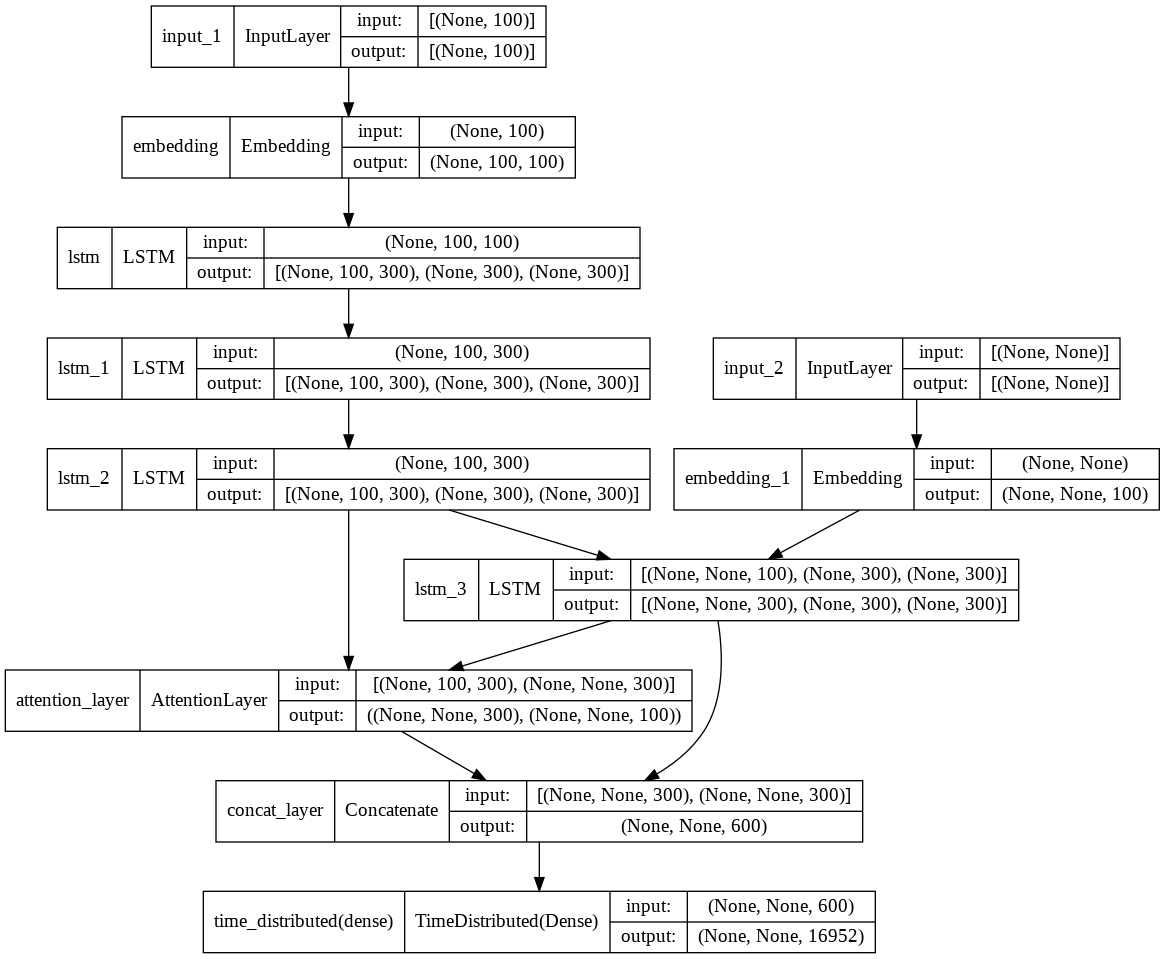

In [ ]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train Model Seq2Seq

In [ ]:
# history=model.fit(x_tr, y_tr,epochs=50,callbacks=[es],batch_size=128, validation_data=(x_val,y_val))

# history=model.fit([X_train_encoded,y_train_encoded[:,:]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
#                   epochs=50,callbacks=[es],
#                   batch_size=256, 
#                   validation_data=([X_dev_encoded,y_dev_encoded[:,:]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))

history=model.fit([X_train_encoded,y_train_encoded[:,:-1]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=256,
                  validation_data=([X_dev_encoded,y_dev_encoded[:,:-1]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))



Epoch 1/50
196/196 [==============================] - 518s 3s/step - loss: 2.6699 - val_loss: 2.4156
Epoch 2/50
196/196 [==============================] - 500s 3s/step - loss: 2.3409 - val_loss: 2.2498
Epoch 3/50
196/196 [==============================] - 499s 3s/step - loss: 2.1808 - val_loss: 2.0840
Epoch 4/50
194/196 [============================>.] - ETA: 4s - loss: 2.0243

# Seq2Seq no attention

## Define layers

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
num_wordsX = len(word_to_index)
num_wordsy = len(yword_to_index)

print("Size of vocabulary from the w2v model = {}".format(num_wordsX))
MAX_LEN=100
K.clear_session()

latent_dim = 300
embedding_dim=300

# Encoder
encoder_inputs = Input(shape=(MAX_LEN, ))

#embedding layer
enc_emb =  Embedding(input_dim=num_wordsX, 
                     output_dim=embedding_dim,
                     embeddings_initializer=Constant(embedding_matrixX),
                     trainable=True,
                     input_length = MAX_LEN
                     
                     )(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(input_dim=num_wordsy,
                          output_dim=embedding_dim,
                          trainable=True,
                          embeddings_initializer=Constant(embedding_matrixy),
                          input_length=MAX_LEN)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(num_wordsy, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model_2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_2.summary()

## Build mô hình seq2seq

In [ ]:
model_2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model_2.summary()

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

## Train mô hình seq2seq

In [ ]:
history=model_2.fit([X_train_encoded,y_train_encoded[:,:-1]], y_train_encoded.reshape(y_train_encoded.shape[0],y_train_encoded.shape[1], 1)[:,1:] ,
                  epochs=50,callbacks=[es],
                  batch_size=256,
                  validation_data=([X_dev_encoded,y_dev_encoded[:,:-1]], y_dev_encoded.reshape(y_dev_encoded.shape[0],y_dev_encoded.shape[1], 1)[:,1:]))

# Define Encode and Decode

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(MAX_LEN,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


#Attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

#Adding Dense softmax layer to generate proability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

NameError: ignored

In [ ]:
#Visualize the Decode
from tensorflow.keras.utils import plot_model

plot_model(decoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: ignored

In [ ]:
#Visualize the Encode
from tensorflow.keras.utils import plot_model

plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
with open('/content/drive/MyDrive/nam3/course/nlp/encoder_50_model.json', 'w', encoding='utf8') as f:
    f.write(encoder_model.to_json())
encoder_model.save_weights('/content/drive/MyDrive/nam3/course/nlp/encoder_model_50_seq2seq_vitokenizer.h5')

with open('/content/drive/MyDrive/nam3/course/nlp/decoder_50_model.json', 'w', encoding='utf8') as f:
    f.write(decoder_model.to_json())
decoder_model.save_weights('/content/drive/MyDrive/nam3/course/nlp/decoder_model_50_seq2seq_vitokenizer.h5')

# Functions to create Summary text

In [23]:
reverse_target_word_index=yword_tokenizer.index_word
reverse_source_word_index=word_tokenizer.index_word
target_word_index=yword_tokenizer.word_index

## Decode sequence with greedy_search

Các bước decode_sequence
+ chạy encoder trước với input là một chuỗi để lấy đươc output, h, c
+ Khởi tạo target sequence
+ Tạo start word, stop condition, decoded_sentence
+ Vòng while
  + chạy doceder với inpur là từ ở target_seq + e_out, e_h, e_c
  + Chọn từ được dự đoán cập nhận lại e_h và e_c

In [24]:
def decode_sequence_greedy_search(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (100-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## Decode sequence with beam search

In [25]:
import numpy as np
from math import log

In [26]:
def decode_sequence_beam_search(input_seq,beam_width):
    # variable that save top options
    distributions_scores_states = [[list(), 0.0, [None, None]]]
    
    stop_condition = False

    while not stop_condition:
        sequence_temp_candidates = list()

        # get state to input next cell for each candidate
        for i in range (len(distributions_scores_states)):
          # Generate empty target sequence of length 1.
          target_seq = np.zeros((1,1))

          # get sequence, scores, states value of top options
          seq, score, states_values = distributions_scores_states[i]

          if len(distributions_scores_states)==1:
            # get state from encoder model
            e_out, e_h, e_c = encoder_model.predict(input_seq)

            # first sequence is 'sostok' to start a sequence
            target_seq[0, 0] = target_word_index['sostok']

          else:
             # get previous word and its state values
             target_seq[0,0]=seq[-1]
             e_h = states_values[0]
             e_c = states_values[1]
          
          # if previous word is 'eostok' that end of sentance, save that sentance in to sequence_temo_candidates
          if target_seq==target_word_index['eostok']:
            sequence_temp_candidates.append(distributions_scores_states[i])
          else: 
            # get output token, h, c
            output_tokens_distribution, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
            # update states
            states_values=[h,c]

            # get distribution of predicted word
            predicted_distribution=output_tokens_distribution[0,0]
            
            # calculate score and save candidate words 
            for j in range(len(predicted_distribution)):
              if predicted_distribution[j]>0:
                candidate = [seq + [j], score - log(predicted_distribution[j]), states_values]
                sequence_temp_candidates.append(candidate)

        # order candiate words
        ordered = sorted(sequence_temp_candidates, key=lambda tup:tup[1])
        # get n words
        distributions_scores_states = ordered[:beam_width]
        
        # check condition to stop searching
        stop_condition = True
        for i in range(beam_width):
          seq, score, states_values = distributions_scores_states[i]
          # print(len(seq))
          if (seq[-1]!=target_word_index['eostok']):
            stop_condition = False
          if len(seq) >= (100-1):
            stop_condition = True
            break

    # get result     
    seq, score, states_values = distributions_scores_states[0]
    result_sentance =''
    for token_index in seq:
      if token_index == target_word_index['eostok']:
          break
      word = reverse_target_word_index[token_index]
      result_sentance+=word + " "

    return result_sentance

##Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews


In [27]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+str(reverse_target_word_index[i])+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+str(reverse_source_word_index[i])+' '
    return newString

# Load model and Predict

## Glove

In [21]:
from keras.models import model_from_json

In [22]:
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read(), custom_objects={'AttentionLayer': AttentionLayer})
    model.load_weights(model_weights_filename)
    return model

encoder_model = load_model('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/glove_attention/encoder_50_model_glove_attention.json', '/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/glove_attention/encoder_model_50_seq2seq_vitokenizer_glove_attention.h5')
decoder_model = load_model('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/glove_attention/decoder_50_model_glove_attention.json', '/content/drive/MyDrive/Code Tổng Hợp Đồ Án/dataset/glove_attention/decoder_model_50_seq2seq_vitokenizer_glove_attention.h5')

In [28]:
for i in range(1864,3000): 
    print("Predicted summary:", i)
    string=str(decode_sequence_beam_search(X_test_encoded[i].reshape(1,100),3))+'\n'
    with open("/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_beam_glove_1864-3000.txt", "a") as file_object:
      # Append 'hello' at the end of file
      file_object.write(string)

Predicted summary: 1366
Predicted summary: 1367
Predicted summary: 1368
Predicted summary: 1369
Predicted summary: 1370
Predicted summary: 1371
Predicted summary: 1372
Predicted summary: 1373
Predicted summary: 1374
Predicted summary: 1375
Predicted summary: 1376
Predicted summary: 1377
Predicted summary: 1378
Predicted summary: 1379
Predicted summary: 1380
Predicted summary: 1381
Predicted summary: 1382
Predicted summary: 1383
Predicted summary: 1384
Predicted summary: 1385
Predicted summary: 1386
Predicted summary: 1387
Predicted summary: 1388
Predicted summary: 1389
Predicted summary: 1390
Predicted summary: 1391
Predicted summary: 1392
Predicted summary: 1393
Predicted summary: 1394
Predicted summary: 1395
Predicted summary: 1396
Predicted summary: 1397
Predicted summary: 1398
Predicted summary: 1399
Predicted summary: 1400
Predicted summary: 1401
Predicted summary: 1402
Predicted summary: 1403
Predicted summary: 1404
Predicted summary: 1405
Predicted summary: 1406
Predicted summar

In [ ]:
data_pred = pd.DataFrame(list_pred, columns = ['Predict'])
data_pred.to_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_no_attention_greddy_300dims_.csv', encoding='utf-8')

## Attention

In [ ]:
from keras.models import model_from_json

In [ ]:
def load_model(model_filename, model_weights_filename):
    with open(model_filename, 'r', encoding='utf8') as f:
        model = model_from_json(f.read(), custom_objects={'AttentionLayer': AttentionLayer})
    model.load_weights(model_weights_filename)
    return model

encoder_model = load_model('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/seq2seq/model/encoder_50_model.json', '/content/drive/MyDrive/Code Tổng Hợp Đồ Án/seq2seq/model/encoder_model_50_seq2seq_vitokenizer.h5')
decoder_model = load_model('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/seq2seq/model/decoder_50_model.json', '/content/drive/MyDrive/Code Tổng Hợp Đồ Án/seq2seq/model/decoder_model_50_seq2seq_vitokenizer.h5')

In [ ]:
for i in range(9996,10000): 
    print("Predicted summary:", i)
    string=str(decode_sequence_greedy_search(X_test_encoded[i].reshape(1,100)))+'\n'
    with open("/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_greddy_300dims_0-10000.txt", "a") as file_object:
      # Append 'hello' at the end of file
      file_object.write(string)

Predicted summary: 9996
Predicted summary: 9997
Predicted summary: 9998
Predicted summary: 9999


In [ ]:
data_pred = pd.DataFrame(list_pred, columns = ['Predict'])
data_pred.to_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_greddy_300dims_.csv', encoding='utf-8')

# Kết quả và đánh giá

In [ ]:
!pip install rouge/requirements.txt
!pip install rouge-score

ERROR: Invalid requirement: 'rouge/requirements.txt'
Hint: It looks like a path. File 'rouge/requirements.txt' does not exist.


## No attention

In [ ]:
import pandas as pd

In [ ]:
file_1 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_no_attention_greddy_300dims_0-10000.txt',header=None) # đủ 0-9999

file_2 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_no_attention_greddy_300dims_10000-13175.txt', header=None) # 10000-13190

file_2 = file_2.iloc[0:3176,:]

file_3 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_no_attention_greddy_300dims_13176-end.txt', header=None) # 13176-22463


In [ ]:
result = file_1.append([file_2, file_3])

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

rouge_1=[]
rouge_2=[]
rouge_L=[]

for i in range(0,10000):
  scores=scorer.score(result.iloc[i,-1],df_test.summary[i])
  rouge_1.append(list(scores['rouge1'][0:3])) # Đúng kiểu là sẽ kết hợp đc hết
  rouge_2.append(list(scores['rouge2'][0:3]))
  rouge_L.append(list(scores['rougeL'][0:3]))

rouge_1=pd.DataFrame(rouge_1,columns=['precision','recall','fmeasure'])
rouge_2=pd.DataFrame(rouge_2,columns=['precision','recall','fmeasure'])
rouge_L=pd.DataFrame(rouge_L,columns=['precision','recall','fmeasure'])

In [ ]:
for i in ['precision','recall','fmeasure']:
  print(f'Test {i} score')
  print(f'Rouge_1: {rouge_1[i].mean()}')
  print(f'Rouge_2: {rouge_2[i].mean()}')
  print(f'Rouge_L: {rouge_L[i].mean()} \n')

Test precision score
Rouge_1: 0.4597337470495689
Rouge_2: 0.10857564195011103
Rouge_L: 0.26967894552175364 

Test recall score
Rouge_1: 0.5307796420323136
Rouge_2: 0.12670081026118304
Rouge_L: 0.3111342660730006 

Test fmeasure score
Rouge_1: 0.4814936169743063
Rouge_2: 0.11418940170385095
Rouge_L: 0.28214274118422084 



## Attention

In [ ]:
file_1 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_greddy_300dims_0-10000.txt',header=None) #0-9995

file_2 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_greddy_300dims_10000-13809.txt', header=None) #10000-15438

file_2=file_2.iloc[0:3810,:]

file_3 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/predict_full_attention_greddy_300dims_13810.txt', header=None) #13810 - end 


In [ ]:
result = file_1.append([file_2, file_3])

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

rouge_1=[]
rouge_2=[]
rouge_L=[]

for i in range(0,10000):
  scores=scorer.score(result.iloc[i,-1],df_test.summary[i])
  rouge_1.append(list(scores['rouge1'][0:3])) # Đúng kiểu là sẽ kết hợp đc hết
  rouge_2.append(list(scores['rouge2'][0:3]))
  rouge_L.append(list(scores['rougeL'][0:3]))

rouge_1=pd.DataFrame(rouge_1,columns=['precision','recall','fmeasure'])
rouge_2=pd.DataFrame(rouge_2,columns=['precision','recall','fmeasure'])
rouge_L=pd.DataFrame(rouge_L,columns=['precision','recall','fmeasure'])

In [ ]:
for i in ['precision','recall','fmeasure']:
  print(f'Test {i} score')
  print(f'Rouge_1: {rouge_1[i].mean()}')
  print(f'Rouge_2: {rouge_2[i].mean()}')
  print(f'Rouge_L: {rouge_L[i].mean()} \n')

Test precision score
Rouge_1: 0.3915059893871735
Rouge_2: 0.05828802496240646
Rouge_L: 0.23002318550078135 

Test recall score
Rouge_1: 0.4933020730617342
Rouge_2: 0.07510777001428547
Rouge_L: 0.29077713144594197 

Test fmeasure score
Rouge_1: 0.4230498972475624
Rouge_2: 0.06348049070052045
Rouge_L: 0.24859141903686136 



## Attention + Beam_search

In [ ]:
file_1 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/file1csv') #0-9995

file_2 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/file2csv',) #10000-15438

file_3 = pd.read_csv('/content/drive/MyDrive/Code Tổng Hợp Đồ Án/Hierarchical/file3csv',) #13810 - end 


In [ ]:
result = file_1.append([file_2, file_3])

In [ ]:
result.reset_index(drop=True, inplace=True)

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

rouge_1=[]
rouge_2=[]
rouge_L=[]

for i in range(0,10000):
  scores=scorer.score(result.iloc[i,-1],df_test.summary[i])
  rouge_1.append(list(scores['rouge1'][0:3])) # Đúng kiểu là sẽ kết hợp đc hết
  rouge_2.append(list(scores['rouge2'][0:3]))
  rouge_L.append(list(scores['rougeL'][0:3]))

rouge_1=pd.DataFrame(rouge_1,columns=['precision','recall','fmeasure'])
rouge_2=pd.DataFrame(rouge_2,columns=['precision','recall','fmeasure'])
rouge_L=pd.DataFrame(rouge_L,columns=['precision','recall','fmeasure'])

In [ ]:
for i in ['precision','recall','fmeasure']:
  print(f'Test {i} score')
  print(f'Rouge_1: {rouge_1[i].mean()}')
  print(f'Rouge_2: {rouge_2[i].mean()}')
  print(f'Rouge_L: {rouge_L[i].mean()} \n')

Test precision score
Rouge_1: 0.4191386717298941
Rouge_2: 0.10458735269148225
Rouge_L: 0.25399224718606295 

Test recall score
Rouge_1: 0.5546778484484028
Rouge_2: 0.14030884256749876
Rouge_L: 0.33635786504357 

Test fmeasure score
Rouge_1: 0.46536227401085434
Rouge_2: 0.11681295374860119
Rouge_L: 0.28178129883461533 

